# Support Vector Machine notebook (Female)

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [2]:
alzheimer = pd.read_csv('adni_ixi_rois_data_raw.csv', delimiter=',',header=0)
print(alzheimer.shape)
print(alzheimer.head())
print(alzheimer.info())
print(alzheimer.describe())

(2436, 453)
   lh_bankssts_area  lh_caudalanteriorcingulate_area  \
0               879                              528   
1               845                              525   
2               884                              605   
3               846                              612   
4               834                              324   

   lh_caudalmiddlefrontal_area  lh_cuneus_area  lh_entorhinal_area  \
0                         1968            1072                 253   
1                         1892            1064                 285   
2                         2093            1449                 524   
3                         2035            1485                 521   
4                         2140            1518                 309   

   lh_fusiform_area  lh_inferiorparietal_area  lh_inferiortemporal_area  \
0              2307                      3573                      2445   
1              2232                      3670                      2383   
2    

In [3]:
#Check for missign values
total=alzheimer.isnull().sum().sort_values(ascending=False)
percent = round(alzheimer.isnull().sum().sort_values(ascending = False)/len(alzheimer)*100, 2)
pd.concat([total, percent], axis = 1,keys= ['Total', 'Percent'])


,Total,Percent
Age,0,0.0
lh_superiortemporal_volume,0,0.0
lh_caudalmiddlefrontal_volume,0,0.0
lh_cuneus_volume,0,0.0
lh_entorhinal_volume,0,0.0
...,...,...
rh_superiortemporal_thickness,0,0.0
rh_supramarginal_thickness,0,0.0
rh_frontalpole_thickness,0,0.0
rh_temporalpole_thickness,0,0.0


In [4]:
#Remove attributes with 0s and systematically inconsistent
alzheimers=alzheimer.drop(['eTIV', '5th-Ventricle', 'Left-WM-hypointensities','Right-WM-hypointensities','non-WM-hypointensities','Left-non-WM-hypointensities','Right-non-WM-hypointensities','Left-vessel','Right-vessel','lhSurfaceHoles','rhSurfaceHoles','SurfaceHoles'], axis = 1)
print(alzheimers.shape)

noisefiltered=alzheimers[alzheimers['total CNR']>0.9]
print(noisefiltered.head())
print(noisefiltered.shape)

sortedfiltered=noisefiltered.sort_values('SID', ascending=False)
print(sortedfiltered.head())
print(sortedfiltered.shape)

(2436, 441)
   lh_bankssts_area  lh_caudalanteriorcingulate_area  \
0               879                              528   
1               845                              525   
2               884                              605   
3               846                              612   
4               834                              324   

   lh_caudalmiddlefrontal_area  lh_cuneus_area  lh_entorhinal_area  \
0                         1968            1072                 253   
1                         1892            1064                 285   
2                         2093            1449                 524   
3                         2035            1485                 521   
4                         2140            1518                 309   

   lh_fusiform_area  lh_inferiorparietal_area  lh_inferiortemporal_area  \
0              2307                      3573                      2445   
1              2232                      3670                      2383   
2    

In [5]:
#Filter out duplicate values, keeping the first value
duplicates=sortedfiltered.drop_duplicates(subset='SID',keep = 'first') 
print(duplicates.head())
print(duplicates.info())


      lh_bankssts_area  lh_caudalanteriorcingulate_area  \
2237              1382                              399   
2236              1031                              604   
2235              1115                              604   
2234               984                              601   
2233              1039                              514   

      lh_caudalmiddlefrontal_area  lh_cuneus_area  lh_entorhinal_area  \
2237                         2328            1713                 536   
2236                         2334            1628                 382   
2235                         2674            1805                 406   
2234                         2513            1494                 575   
2233                         2305            1964                 463   

      lh_fusiform_area  lh_inferiorparietal_area  lh_inferiortemporal_area  \
2237              4280                      5523                      4045   
2236              2709                      5016  

In [6]:
#Encode labels and drop unecessary columns
label_quality = LabelEncoder()
duplicates['Research Group'] = label_quality.fit_transform(duplicates['Research Group'])
train=duplicates.copy()
train.drop(['Age','SID', 'total CNR','Study'], axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1215 entries, 2237 to 767
Columns: 437 entries, lh_bankssts_area to Research Group
dtypes: float64(284), int64(152), object(1)
memory usage: 4.1+ MB


/home/fs838120/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
#filter out by male and female
male=train[train['Gender']=='M']
male.shape
male.head()
male.info()

female=train[train['Gender']=='F']
female.shape
female.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 2237 to 767
Columns: 437 entries, lh_bankssts_area to Research Group
dtypes: float64(284), int64(152), object(1)
memory usage: 1.9+ MB


,lh_bankssts_area,lh_caudalanteriorcingulate_area,lh_caudalmiddlefrontal_area,lh_cuneus_area,lh_entorhinal_area,lh_fusiform_area,lh_inferiorparietal_area,lh_inferiortemporal_area,lh_isthmuscingulate_area,lh_lateraloccipital_area,...,right_parasubiculum,right_molecular_layer_HP,right_GC-ML-DG,right_CA3,right_CA4,right_fimbria,right_HATA,right_Whole_hippocampus,Gender,Research Group
2220,862,530,2037,1289,535,2929,3952,3047,819,4568,...,46.461919,434.595503,231.404698,162.388210,197.017748,70.285099,56.145862,2857.525319,F,1
2219,816,547,2181,1408,513,2911,3146,2675,838,4583,...,50.964043,539.436587,284.107845,190.369238,238.195497,79.764626,66.806796,3344.279277,F,1
2216,899,607,1827,1365,378,3123,4316,3046,787,5403,...,32.580984,532.200366,292.456888,210.220181,250.866354,33.304657,62.685547,3150.591207,F,1
2210,880,779,1821,1507,375,3069,4479,3630,925,4488,...,48.457593,581.810977,327.605965,251.333255,279.380102,59.665453,54.737106,3514.416839,F,1
2208,859,571,1602,1272,264,2551,3907,2887,711,4722,...,39.616299,461.266237,260.890460,199.302961,220.133679,43.914119,47.364900,2811.495889,F,1


In [9]:
#Drop category labels and gender labels
y_female = female["Research Group"]
X_female = female.drop(["Research Group",'Gender'], axis = 1)

In [10]:
#Normalise the data between 0 and 1
sc=StandardScaler()
X_scaled_female = sc.fit_transform(X_female)

In [11]:
#Train test splic
X_train, X_test, y_train, y_test = train_test_split(X_scaled_female, y_female,test_size = 0.3, random_state=42)   #scale the test data as well

In [12]:

#Initiate the classifier
clf = SVC(kernel='linear') # Linear Kernel
#Train the model using the training sets
clf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [13]:
#Print out the statistics from the classifier
print ("So, Our accuracy Score is: {}".format(round(accuracy_score(y_pred, y_test),4)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

So, Our accuracy Score is: 0.9375
[[ 42   7]
 [  5 138]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        49
           1       0.95      0.97      0.96       143

    accuracy                           0.94       192
   macro avg       0.92      0.91      0.92       192
weighted avg       0.94      0.94      0.94       192



0.9110889110889111


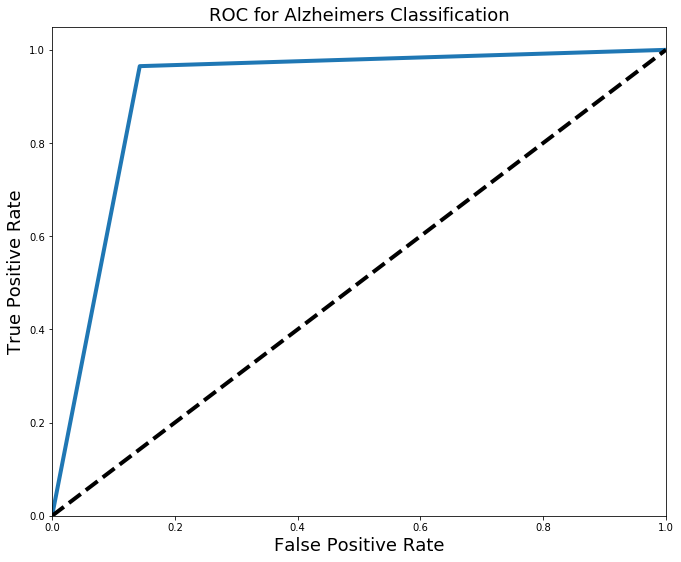

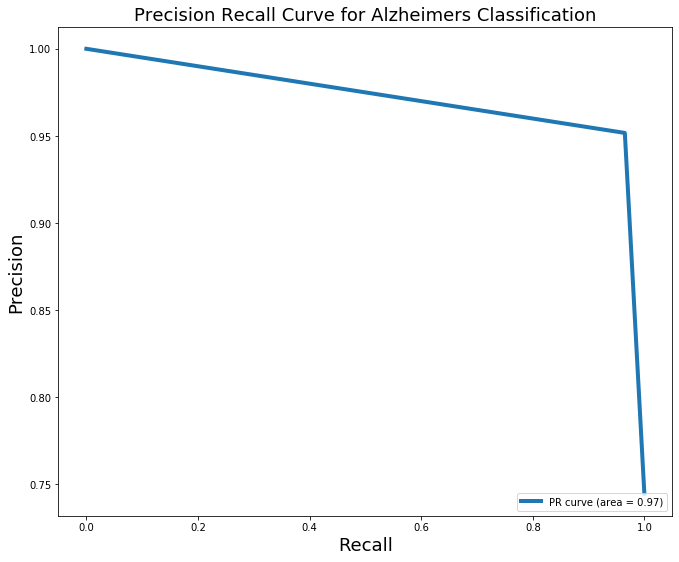

In [14]:
#Validating the fit
#AUC & ROC Curve
FPR, TPR, _ = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

plt.figure(figsize =[11,9])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Alzheimers Classification', fontsize= 18)
plt.show()
#Precision recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PR_AUC = auc(recall, precision)

plt.figure(figsize=[11,9])
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision Recall Curve for Alzheimers Classification', fontsize=18)
plt.legend(loc="lower right")
plt.show()


In [15]:
#Now with cross validation 10 fold
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .4, random_state = 42 )
accuracies = cross_val_score(clf, X_train,y_train, cv  = cv, scoring='accuracy')
print ("Cross-Validation accuracy scores:{}".format(accuracies))
print ("Mean Cross-Validation accuracy score: {}".format(round(accuracies.mean(),5)))

Cross-Validation accuracy scores:[0.9        0.9        0.9        0.9        0.9        0.94444444
 0.88333333 0.90555556 0.93333333 0.90555556]
Mean Cross-Validation accuracy score: 0.90722


In [21]:
#initiate grid search 
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=42)
paramgrid = {"kernel" :["linear", "rbf", "poly"],"C":np.arange(5,20),"gamma":[1e-12,1e-8,1e-4],"degree" : [0, 1, 2, 3, 4, 5, 6]}
model=SVC()
model_grid = GridSearchCV(model,paramgrid,cv=cv,iid=False)
model_grid.fit(X_train,y_train)
print(model_grid.best_params_)
print(model_grid.best_score_)

svc_ran_grid = model_grid.best_estimator_
svc_ran_grid.score(X_test,y_test)
y_pred = svc_ran_grid.predict(X_test)

{'C': 11, 'degree': 0, 'gamma': 0.0001, 'kernel': 'rbf'}
0.9199999999999999


So, Our accuracy Score is: 0.9531
[[ 40   9]
 [  0 143]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        49
           1       0.94      1.00      0.97       143

    accuracy                           0.95       192
   macro avg       0.97      0.91      0.93       192
weighted avg       0.96      0.95      0.95       192

0.9081632653061225


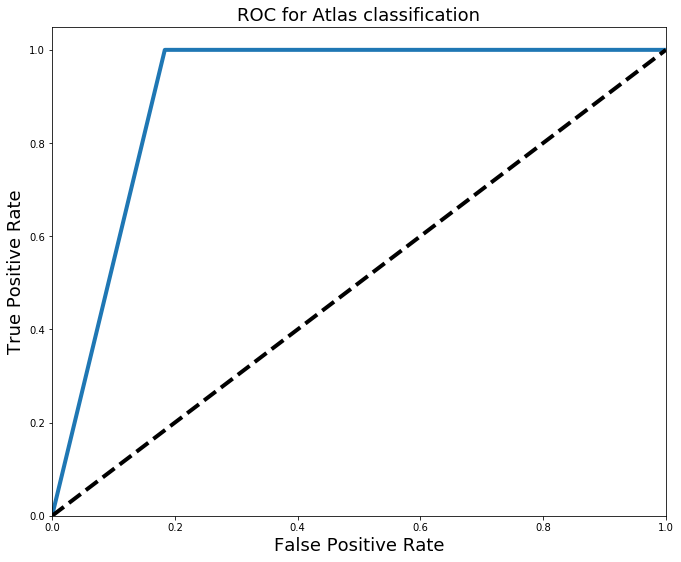

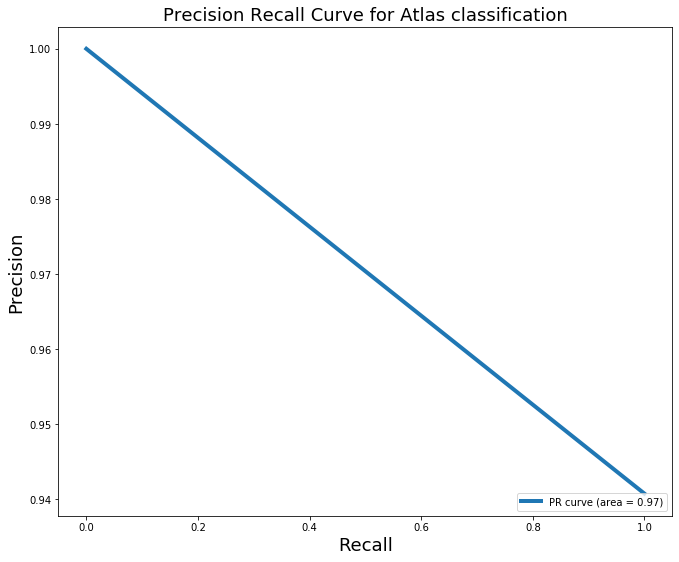

In [22]:
print ("So, Our accuracy Score is: {}".format(round(accuracy_score(y_pred, y_test),4)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

FPR, TPR, _ = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

plt.figure(figsize =[11,9])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Atlas classification', fontsize= 18)
plt.show()
#Precision recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PR_AUC = auc(recall, precision)

plt.figure(figsize=[11,9])
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision Recall Curve for Atlas classification', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Bagging and Boosting

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier


In [24]:
#Initiate the classifier
clf = XGBClassifier() # Linear Kernel
#Train the model using the training sets
clf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [25]:
#Print out the statistics from the classifier
print ("So, Our accuracy Score is: {}".format(round(accuracy_score(y_pred, y_test),4)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

So, Our accuracy Score is: 0.9375
[[ 38  11]
 [  1 142]]
              precision    recall  f1-score   support

           0       0.97      0.78      0.86        49
           1       0.93      0.99      0.96       143

    accuracy                           0.94       192
   macro avg       0.95      0.88      0.91       192
weighted avg       0.94      0.94      0.94       192



In [27]:
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=42)
paramgrid = {'n_estimators':range(100,500,100),'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}
model=XGBClassifier()
model_grid = GridSearchCV(model,paramgrid,cv=cv,iid=False)
model_grid.fit(X_train,y_train)
print(model_grid.best_params_)
print(model_grid.best_score_)

xgb_grid = model_grid.best_estimator_
xgb_grid.score(X_test,y_test)
y_pred = xgb_grid.predict(X_test)

{'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200}
0.9051851851851852


In [28]:
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .4, random_state = 42 )
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = XGBClassifier(max_depth=5, min_child_weight=3, n_estimators=200)
estimators.append(('cart', model2))
model3 = SVC(C= 10, degree= 0, gamma= 0.0001, kernel= 'rbf')
estimators.append(('svm', model3))

In [29]:
# create the ensemble model
ensemble = VotingClassifier(estimators,voting='hard')
results = ensemble.fit(X_train,y_train)
ensemble.score(X_test,y_test)

/home/fs838120/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.953125

In [30]:
accuracies = cross_val_score(ensemble, X_train,y_train, cv  = cv, scoring='accuracy')
print ("Cross-Validation accuracy scores:{}".format(accuracies))
print ("Mean Cross-Validation accuracy score: {}".format(round(accuracies.mean(),5)))

/home/fs838120/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/fs838120/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/fs838120/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/fs838120/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/fs838120/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Cross-Validation accuracy scores:[0.9        0.93333333 0.93333333 0.91666667 0.92222222 0.92777778
 0.89444444 0.91111111 0.95       0.9       ]
Mean Cross-Validation accuracy score: 0.91889


In [31]:
y_pred = ensemble.predict(X_test)

So, Our accuracy Score is: 0.9531
[[ 40   9]
 [  0 143]]
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        49
           1       0.94      1.00      0.97       143

    accuracy                           0.95       192
   macro avg       0.97      0.91      0.93       192
weighted avg       0.96      0.95      0.95       192

0.9081632653061225


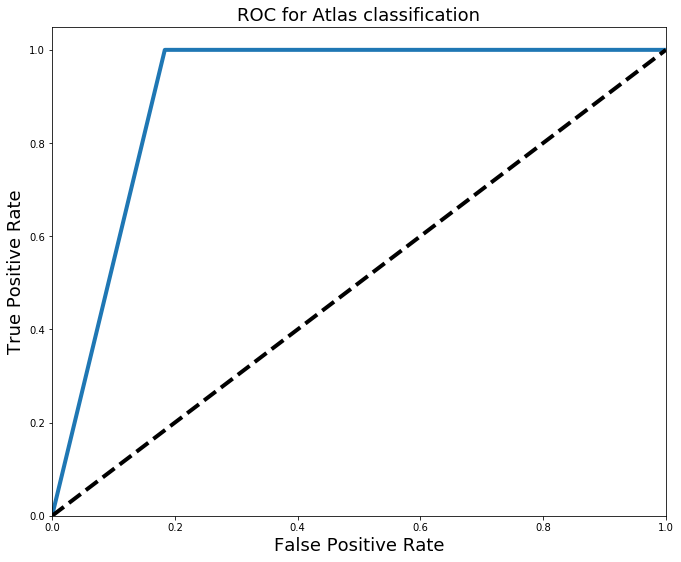

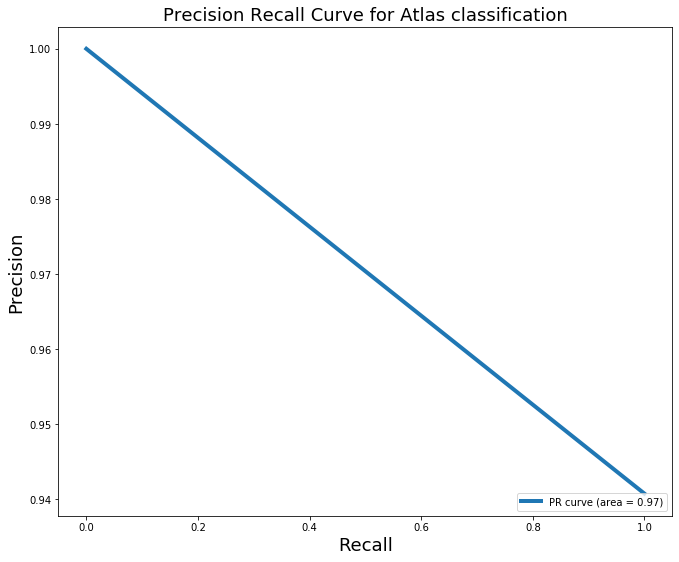

In [32]:
print ("So, Our accuracy Score is: {}".format(round(accuracy_score(y_pred, y_test),4)))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

FPR, TPR, _ = roc_curve(y_test, y_pred)
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)

plt.figure(figsize =[11,9])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Atlas classification', fontsize= 18)
plt.show()
#Precision recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
PR_AUC = auc(recall, precision)

plt.figure(figsize=[11,9])
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % PR_AUC, linewidth=4)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision Recall Curve for Atlas classification', fontsize=18)
plt.legend(loc="lower right")
plt.show()